# Tutorial 11: Normalizing Flows for image modeling

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View notebook on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial11/NF_image_modeling.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial11/NF_image_modeling.ipynb)  
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial11)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1gttZ5DSrpKwn9g3RcizqA5qG7NFLMgvv?usp=sharing)   
**Recordings:** 
[![YouTube - Part 1](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%201&color=red)](https://youtu.be/U1fwesIusbg)
[![YouTube - Part 2](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%202&color=red)](https://youtu.be/qMoGcRhVrF8)
[![YouTube - Part 3](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%203&color=red)](https://youtu.be/YoAWiaEt41Y)
[![YouTube - Part 4](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%204&color=red)](https://youtu.be/nTyDvn-ADJ4)    
**JAX+Flax version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial11/NF_image_modeling.html)     
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** Interested in JAX? Check out our [JAX+Flax version](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial11/NF_image_modeling.html) of this tutorial!
</div>

In this tutorial, we will take a closer look at complex, deep normalizing flows. The most popular, current application of deep normalizing flows is to model datasets of images. As for other generative models, images are a good domain to start working on because (1) CNNs are widely studied and strong models exist, (2) images are high-dimensional and complex, and (3) images are discrete integers. In this tutorial, we will review current advances in normalizing flows for image modeling, and get hands-on experience on coding normalizing flows. Note that normalizing flows are commonly parameter heavy and therefore computationally expensive. We will use relatively simple and shallow flows to save computational cost and allow you to run the notebook on CPU, but keep in mind that a simple way to improve the scores of the flows we study here is to make them deeper. 

Throughout this notebook, we make use of [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/). The first cell imports our usual libraries.

In [1]:
## Standard libraries
import os
import math
import time
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
#try:
#    import pytorch_lightning as pl
#except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
#    !pip install --quiet pytorch-lightning>=1.4
#    import pytorch_lightning as pl
#from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import wandb
wandb.login()

# lighting.torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial11"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipykernel_1087222/1074175564.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
wandb: Currently logged in as: yufeng-jin (greek). Use `wandb login --relogin` to force relogin
Seed set to 42


Using device cuda:0


Again, we have a few pretrained models. We download them below to the specified path above.

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial11/"
# Files to download
pretrained_files = ["MNISTFlow_simple.ckpt", "MNISTFlow_vardeq.ckpt", "MNISTFlow_multiscale.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
# for file_name in pretrained_files:
#     file_path = os.path.join(CHECKPOINT_PATH, file_name)
#     if not os.path.isfile(file_path):
#         file_url = base_url + file_name
#         print(f"Downloading {file_url}...")
#         try:
#             urllib.request.urlretrieve(file_url, file_path)
#         except HTTPError as e:
#             print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

We will use the MNIST dataset in this notebook. MNIST constitutes, despite its simplicity, a challenge for small generative models as it requires the global understanding of an image. At the same time, we can easily judge whether generated images come from the same distribution as the dataset (i.e. represent real digits), or not.

To deal better with the discrete nature of the images, we transform them from a range of 0-1 to a range of 0-255 as integers.

In [3]:
# Convert images from 0-1 to 0-255 (integers)
def discretize(sample):
    return (sample * 255).to(torch.int32)

# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

Seed set to 42


In addition, we will define below a function to simplify the visualization of images/samples. Some training examples of the MNIST dataset is shown below.

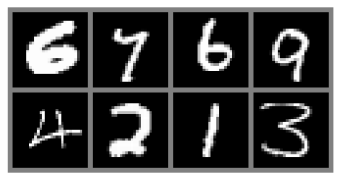

In [4]:
def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

## Normalizing Flows as generative model

In the previous lectures, we have seen Energy-based models, Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs) as example of generative models. However, none of them explicitly learn the probability density function $p(x)$ of the real input data. While VAEs model a lower bound, energy-based models only implicitly learn the probability density. GANs on the other hand provide us a sampling mechanism for generating new data, without offering a likelihood estimate. The generative model we will look at here, called Normalizing Flows, actually models the true data distribution $p(x)$ and provides us with an exact likelihood estimate. Below, we can visually compare VAEs, GANs and Flows
(figure credit - [Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)):

<center width="100%"><img src="comparison_GAN_VAE_NF.png" width="600px"></center>

The major difference compared to VAEs is that flows use *invertible* functions $f$ to map the input data $x$ to a latent representation $z$. To realize this, $z$ must be of the same shape as $x$. This is in contrast to VAEs where $z$ is usually much lower dimensional than the original input data. However, an invertible mapping also means that for every data point $x$, we have a corresponding latent representation $z$ which allows us to perform lossless reconstruction ($z$ to $x$). In the visualization above, this means that $x=x'$ for flows, no matter what invertible function $f$ and input $x$ we choose. 

Nonetheless, how are normalizing flows modeling a probability density with an invertible function? The answer to this question is the rule for change of variables. Specifically, given a prior density $p_z(z)$ (e.g. Gaussian) and an invertible function $f$, we can determine $p_x(x)$ as follows:

$$
\begin{split}
    \int p_x(x) dx & = \int p_z(z) dz = 1 \hspace{1cm}\text{(by definition of a probability distribution)}\\
    \Leftrightarrow p_x(x) & = p_z(z) \left|\frac{dz}{dx}\right| = p_z(f(x)) \left|\frac{df(x)}{dx}\right|
\end{split}
$$

Hence, in order to determine the probability of $x$, we only need to determine its probability in latent space, and get the derivate of $f$. Note that this is for a univariate distribution, and $f$ is required to be invertible and smooth. For a multivariate case, the derivative becomes a Jacobian of which we need to take the determinant. As we usually use the log-likelihood as objective, we write the multivariate term with logarithms below:

$$
\log p_x(\mathbf{x}) = \log p_z(f(\mathbf{x})) + \log{} \left|\det \frac{df(\mathbf{x})}{d\mathbf{x}}\right|
$$

Although we now know how a normalizing flow obtains its likelihood, it might not be clear what a normalizing flow does intuitively. For this, we should look from the inverse perspective of the flow starting with the prior probability density $p_z(z)$. If we apply an invertible function on it, we effectively "transform" its probability density. For instance, if $f^{-1}(z)=z+1$, we shift the density by one while still remaining a valid probability distribution, and being invertible. We can also apply more complex transformations, like scaling: $f^{-1}(z)=2z+1$, but there you might see a difference. When you scale, you also change the volume of the probability density, as for example on uniform distributions (figure credit - [Eric Jang](https://blog.evjang.com/2018/01/nf1.html)):

<center width="100%"><img src="uniform_flow.png" width="300px"></center>

You can see that the height of $p(y)$ should be lower than $p(x)$ after scaling. This change in volume represents $\left|\frac{df(x)}{dx}\right|$ in our equation above, and ensures that even after scaling, we still have a valid probability distribution. We can go on with making our function $f$ more complex. However, the more complex $f$ becomes, the harder it will be to find the inverse $f^{-1}$ of it, and to calculate the log-determinant of the Jacobian $\log{} \left|\det \frac{df(\mathbf{x})}{d\mathbf{x}}\right|$. An easier trick to stack multiple invertible functions $f_{1,...,K}$ after each other, as all together, they still represent a single, invertible function. Using multiple, learnable invertible functions, a normalizing flow attempts to transform $p_z(z)$ slowly into a more complex distribution which should finally be $p_x(x)$. We visualize the idea below
(figure credit - [Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)):

<center width="100%"><img src="normalizing_flow_layout.png" width="700px"></center>

Starting from $z_0$, which follows the prior Gaussian distribution, we sequentially apply the invertible functions $f_1,f_2,...,f_K$, until $z_K$ represents $x$. Note that in the figure above, the functions $f$ represent the inverted function from $f$ we had above (here: $f:Z\to X$, above: $f:X\to Z$). This is just a different notation and has no impact on the actual flow design because all $f$ need to be invertible anyways. When we estimate the log likelihood of a data point $x$ as in the equations above, we run the flows in the opposite direction than visualized above. Multiple flow layers have been proposed that use a neural network as learnable parameters, such as the planar and radial flow. However, we will focus here on flows that are commonly used in image modeling, and will discuss them in the rest of the notebook along with the details of how to train a normalizing flow.

## Normalizing Flows on images

To become familiar with normalizing flows, especially for the application of image modeling, it is best to discuss the different elements in a flow along with the implementation. As a general concept, we want to build a normalizing flow that maps an input image (here MNIST) to an equally sized latent space:

<center width="100%" style="padding: 10px"><img src="image_to_gaussian.svg" width="450px"></center>

As a first step, we will implement a template of a normalizing flow in PyTorch Lightning. During training and validation, a normalizing flow performs density estimation in the forward direction. For this, we apply a series of flow transformations on the input $x$ and estimate the probability of the input by determining the probability of the transformed point $z$ given a prior, and the change of volume caused by the transformations. During inference, we can do both density estimation and sampling new points by inverting the flow transformations. Therefore, we define a function `_get_likelihood` which performs density estimation, and `sample` to generate new examples. The functions `training_step`, `validation_step` and `test_step` all make use of `_get_likelihood`. 

The standard metric used in generative models, and in particular normalizing flows, is bits per dimensions (bpd). Bpd is motivated from an information theory perspective and describes how many bits we would need to encode a particular example in our modeled distribution. The less bits we need, the more likely the example in our distribution. When we test for the bits per dimension of our test dataset, we can judge whether our model generalizes to new samples of the dataset and didn't memorize the training dataset. In order to calculate the bits per dimension score, we can rely on the negative log-likelihood and change the log base (as bits are binary while NLL is usually exponential):

$$\text{bpd} = \text{nll} \cdot \log_2\left(\exp(1)\right) \cdot \left(\prod d_i\right)^{-1}$$

where $d_1,...,d_K$ are the dimensions of the input. For images, this would be the height, width and channel number. We divide the log likelihood by these extra dimensions to have a metric which we can compare for different image resolutions. In the original image space, MNIST examples have a bits per dimension score of 8 (we need 8 bits to encode each pixel as there are 256 possible values). 

In [5]:
class ImageFlow(pl.LightningModule):
    
    def __init__(self, flows, import_samples=8):
        """
        Inputs:
            flows - A list of flows (each a nn.Module) that should be applied on the images. 
            import_samples - Number of importance samples to use during testing (see explanation below). Can be changed at any time
        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.import_samples = import_samples
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        # Example input for visualizing the graph
        self.example_input_array = train_set[0][0].unsqueeze(dim=0)

    def forward(self, imgs):
        # The forward function is only used for visualizing the graph
        return self._get_likelihood(imgs)

    def encode(self, imgs):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, imgs, return_ll=False):
        """
        Given a batch of images, return the likelihood of those. 
        If return_ll is True, this function returns the log likelihood of the input.
        Otherwise, the ouptut metric is bits per dimension (scaled negative log likelihood)
        """
        ############### Question: what does Encoder return, what does ldj refer to? #################
        ############### Answer: ldj refers to log determinat jacobian, z refers to outputs
        z, ldj = self.encode(imgs)
        log_pz = self.prior.log_prob(z).sum(dim=[1,2,3])
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])    # bpd := -log negative likelihood * exp(1)/
        return bpd.mean() if not return_ll else log_px

    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)
        
        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # An scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch[0])                             
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        # Perform importance sampling during testing => estimate likelihood M times for each image
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(batch[0], return_ll=True)
            samples.append(img_ll)
        img_ll = torch.stack(samples, dim=-1)
        
        # To average the probabilities, we need to go from log-space to exp, and back to log.
        # Logsumexp provides us a stable implementation for this
        img_ll = torch.logsumexp(img_ll, dim=-1) - np.log(self.import_samples)
        
        # Calculate final bpd
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
        bpd = bpd.mean()
        
        self.log('test_bpd', bpd)

The `test_step` function differs from the training and validation step in that it makes use of importance sampling. We will discuss the motiviation and details behind this after understanding how flows model discrete images in continuous space. 

### Dequantization

Normalizing flows rely on the rule of change of variables, which is naturally defined in continuous space. Applying flows directly on discrete data leads to undesired density models where arbitrarly high likelihood are placed on a few, particular values. See the illustration below: 

<center><img src="dequantization_issue.svg" width="40%"/></center>

The black points represent the discrete points, and the green volume the density modeled by a normalizing flow in continuous space. The flow would continue to increase the likelihood for $x=0,1,2,3$ while having no volume on any other point. Remember that in continuous space, we have the constraint that the overall volume of the probability density must be 1 ($\int p(x)dx=1$). Otherwise, we don't model a probability distribution anymore. However, the discrete points $x=0,1,2,3$ represent delta peaks with no width in continuous space. This is why the flow can place an infinite high likelihood on these few points while still representing a distribution in continuous space. Nonetheless, the learned density does not tell us anything about the distribution among the discrete points, as in discrete space, the likelihoods of those four points would have to sum to 1, not to infinity. 

To prevent such degenerated solutions, a common solution is to add a small amount of noise to each discrete value, which is also referred to as dequantization. Considering $x$ as an integer (as it is the case for images), the dequantized representation $v$ can be formulated as $v=x+u$ where $u\in[0,1)^D$.  Thus, the discrete value $1$ is modeled by a distribution over the interval $[1.0, 2.0)$, the value $2$ by an volume over $[2.0, 3.0)$, etc. Our objective of modeling $p(x)$ becomes:

$$ p(x) = \int p(x+u)du = \int \frac{q(u|x)}{q(u|x)}p(x+u)du = \mathbb{E}_{u\sim q(u|x)}\left[\frac{p(x+u)}{q(u|x)} \right]$$

with $q(u|x)$ being the noise distribution. For now, we assume it to be uniform, which can also be written as $p(x)=\mathbb{E}_{u\sim U(0,1)^D}\left[p(x+u) \right]$.

In the following, we will implement Dequantization as a flow transformation itself. After adding noise to the discrete values, we additionally transform the volume into a Gaussian-like shape. **This is done by scaling $x+u$ between $0$ and $1$, and applying the invert of the sigmoid function $\sigma(z)^{-1} = \log z - \log 1-z$.???????????** If we would not do this, we would face two problems: 

1. The input is scaled between 0 and 256 while the prior distribution is a Gaussian with mean $0$ and standard deviation $1$. In the first iterations after initializing the parameters of the flow, we would have extremely low likelihoods for large values like $256$. This would cause the training to diverge instantaneously.
2. As the output distribution is a Gaussian, it is beneficial for the flow to have a similarly shaped input distribution. This will reduce the modeling complexity that is required by the flow.

Overall, we can implement dequantization as follows:

In [6]:
class Dequantization(nn.Module):
    
    def __init__(self, alpha=1e-5, quants=256):
        """
        Inputs:
            alpha - small constant that is used to scale the original input. 
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants - Number of possible discrete values (usually 256 for 8-bit image)
        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants 
        
    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants-1).to(torch.int32)
        return z, ldj
    
    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            ldj += (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
            z = torch.sigmoid(z)
            # Reversing scaling for numerical stability
            ldj -= np.log(1 - self.alpha) * np.prod(z.shape[1:])
            z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1-z)).sum(dim=[1,2,3])
            z = torch.log(z) - torch.log(1-z)
        return z, ldj
    
    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])    # ????????????????? fomula?
        return z, ldj

A good check whether a flow is correctly implemented or not, is to verify that it is invertible. Hence, we will dequantize a randomly chosen training image, and then quantize it again. We would expect that we would get the exact same image out:

In [7]:
## Testing invertibility of dequantization layer
pl.seed_everything(42)
orig_img = train_set[0][0].unsqueeze(dim=0)
ldj = torch.zeros(1,)
dequant_module = Dequantization()
deq_img, ldj = dequant_module(orig_img, ldj, reverse=False)
print(f"........ldj: {ldj}")
reconst_img, ldj = dequant_module(deq_img, ldj, reverse=True)
print(f"........ldj: {ldj}")
d1, d2 = torch.where(orig_img.squeeze() != reconst_img.squeeze())
if len(d1) != 0:
    print("Dequantization was not invertible.")
    for i in range(d1.shape[0]):
        print("Original value:", orig_img[0,0,d1[i], d2[i]].item())
        print("Reconstructed value:", reconst_img[0,0,d1[i], d2[i]].item())
else:
    print("Successfully inverted dequantization")

# Layer is not strictly invertible due to float precision constraints
# assert (orig_img == reconst_img).all().item()

Seed set to 42


........ldj: tensor([-10.0288])
........ldj: tensor([0.])
Successfully inverted dequantization


The test succeeds as we would expect. However, there is a chance that the test fails due to numerical inaccuracies in the sigmoid invert. While the input space to the inverted sigmoid is scaled between 0 and 1, the output space is between $-\infty$ and $\infty$. And as we use 32 bits to represent the numbers (in addition to applying logs over and over again), such inaccuries can occur and should not be worrisome. Nevertheless, it is good to be aware of them, and can be improved by using a double tensor (float64). 

Finally, we can take our dequantization and actually visualize the distribution it transforms the discrete values into:

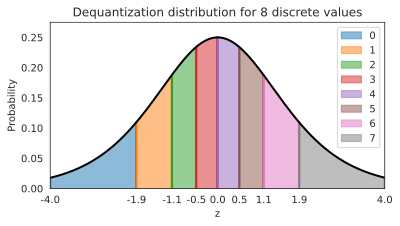

In [8]:
def visualize_dequantization(quants, prior=None):
    """
    Function for visualizing the dequantization values of discrete values in continuous space
    """
    # Prior over discrete values. If not given, a uniform is assumed
    if prior is None:
        prior = np.ones(quants, dtype=np.float32) / quants
    prior = prior / prior.sum()  # Ensure proper categorical distribution

    inp = torch.arange(-4, 4, 0.01).view(-1, 1, 1, 1) # Possible continuous values we want to consider
    ldj = torch.zeros(inp.shape[0])
    dequant_module = Dequantization(quants=quants)
    # Invert dequantization on continuous values to find corresponding discrete value
    out, ldj = dequant_module.forward(inp, ldj, reverse=True)
    inp, out, prob = inp.squeeze().numpy(), out.squeeze().numpy(), ldj.exp().numpy()
    prob = prob * prior[out] # Probability scaled by categorical prior
    
    # Plot volumes and continuous distribution
    sns.set_style("white")
    fig = plt.figure(figsize=(6,3))
    x_ticks = []
    for v in np.unique(out):
        indices = np.where(out==v)
        color = to_rgb(f"C{v}")
        plt.fill_between(inp[indices], prob[indices], np.zeros(indices[0].shape[0]), color=color+(0.5,), label=str(v))
        plt.plot([inp[indices[0][0]]]*2,  [0, prob[indices[0][0]]],  color=color)
        plt.plot([inp[indices[0][-1]]]*2, [0, prob[indices[0][-1]]], color=color)
        x_ticks.append(inp[indices[0][0]])
    x_ticks.append(inp.max())
    plt.xticks(x_ticks, [f"{x:.1f}" for x in x_ticks])
    plt.plot(inp,prob, color=(0.0,0.0,0.0))
    # Set final plot properties
    plt.ylim(0, prob.max()*1.1)
    plt.xlim(inp.min(), inp.max())
    plt.xlabel("z")
    plt.ylabel("Probability")
    plt.title(f"Dequantization distribution for {quants} discrete values")
    plt.legend()
    plt.show()
    plt.close()
    
visualize_dequantization(quants=8)

The visualized distribution show the sub-volumes that are assigned to the different discrete values. The value $0$ has its volume between $[-\infty, -1.9)$, the value $1$ is represented by the interval $[-1.9, -1.1)$, etc. The volume for each discrete value has the same probability mass. That's why the volumes close to the center (e.g. 3 and 4) have a smaller area on the z-axis as others ($z$ is being used to denote the output of the whole dequantization flow).

Effectively, the consecutive normalizing flow models discrete images by the following objective:

$$\log p(x) = \log \mathbb{E}_{u\sim q(u|x)}\left[\frac{p(x+u)}{q(u|x)} \right] \geq \mathbb{E}_{u}\left[\log \frac{p(x+u)}{q(u|x)} \right]$$

<span style='color:red'>Although normalizing flows are exact in likelihood, we have a lower bound. Specifically, this is an example of the Jensen inequality because we need to move the log into the expectation so we can use Monte-carlo estimates. In general, this bound is considerably smaller than the ELBO in variational autoencoders. Actually, we can reduce the bound ourselves by estimating the expectation not by one, but by $M$ samples. In other words, we can apply importance sampling which leads to the following inequality:

$$\log p(x) = \log \mathbb{E}_{u\sim q(u|x)}\left[\frac{p(x+u)}{q(u|x)} \right] \geq \mathbb{E}_{u}\left[\log \frac{1}{M} \sum_{m=1}^{M} \frac{p(x+u_m)}{q(u_m|x)} \right] \geq \mathbb{E}_{u}\left[\log \frac{p(x+u)}{q(u|x)} \right]$$

The importance sampling $\frac{1}{M} \sum_{m=1}^{M} \frac{p(x+u_m)}{q(u_m|x)}$ becomes $\mathbb{E}_{u\sim q(u|x)}\left[\frac{p(x+u)}{q(u|x)} \right]$ if $M\to \infty$, so that the more samples we use, the tighter the bound is. During testing, we can make use of this property and have it implemented in `test_step` in `ImageFlow`. In theory, we could also use this tighter bound during training. However, related work has shown that this does not necessarily lead to an improvement given the additional computational cost, and it is more efficient to stick with a single estimate [5].

### Variational Dequantization

Dequantization uses a uniform distribution for the noise $u$ which effectively leads to images being represented as hypercubes (cube in high dimensions) with sharp borders. However, modeling such sharp borders is not easy for a flow as it uses smooth transformations to convert it into a Gaussian distribution. 

Another way of looking at it is if we change the prior distribution in the previous visualization. Imagine we have independent Gaussian noise on pixels which is commonly the case for any real-world taken picture. Therefore, the flow would have to model a distribution as above, but with the individual volumes scaled as follows:

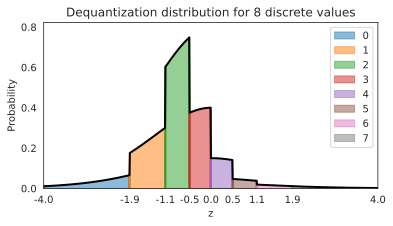

In [9]:
visualize_dequantization(quants=8, prior=np.array([0.075, 0.2, 0.4, 0.2, 0.075, 0.025, 0.0125, 0.0125]))

Transforming such a probability into a Gaussian is a difficult task, especially with such hard borders. Dequantization has therefore been extended to more sophisticated, learnable distributions beyond uniform in a variational framework. In particular, if we remember the learning objective $\log p(x) = \log \mathbb{E}_{u}\left[\frac{p(x+u)}{q(u|x)} \right]$, the uniform distribution can be replaced by a learned distribution $q_{\theta}(u|x)$ with support over $u\in[0,1)^D$. This approach is called Variational Dequantization and has been proposed by Ho et al. [3]. How can we learn such a distribution? We can use a second normalizing flow that takes $x$ as external input and learns a flexible distribution over $u$. To ensure a support over $[0,1)^D$, we can apply a sigmoid activation function as final flow transformation. 

Inheriting the original dequantization class, we can implement variational dequantization as follows: 

In [10]:
class VariationalDequantization(Dequantization):
    
    def __init__(self, var_flows, alpha=1e-5):
        """
        Inputs: 
            var_flows - A list of flow transformations to use for modeling q(u|x)
            alpha - Small constant, see Dequantization for details
        """
        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)
        
    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        img = (z / 255.0) * 2 - 1 # We condition the flows on x, i.e. the original image
        
        # Prior of u is a uniform distribution as before
        # As most flow transformations are defined on [-infinity,+infinity], we apply an inverse sigmoid first.
        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)
        
        # After the flows, apply u as in standard dequantization
        z = (z + deq_noise) / 256.0
        ldj -= np.log(256.0) * np.prod(z.shape[1:])
        return z, ldj

Variational dequantization can be used as a substitute for dequantization. We will compare dequantization and variational dequantization in later experiments. 

### Coupling layers

Next, we look at possible transformations to apply inside the flow. A recent popular flow layer, which works well in combination with deep neural networks, is the coupling layer introduced by Dinh et al. [1]. The input $z$ is arbitrarily split into two parts, $z_{1:j}$ and $z_{j+1:d}$, of which the first remains unchanged by the flow. Yet, $z_{1:j}$ is used to parameterize the transformation for the second part, $z_{j+1:d}$. Various transformations have been proposed in recent time [3,4], but here we will settle for the simplest and most efficient one: affine coupling. In this coupling layer, we apply an affine transformation by shifting the input by a bias $\mu$ and scale it by $\sigma$. In other words, our transformation looks as follows:

$$z'_{j+1:d} = \mu_{\theta}(z_{1:j}) + \sigma_{\theta}(z_{1:j}) \odot z_{j+1:d}$$

The functions $\mu$ and $\sigma$ are implemented as a shared neural network, and the sum and multiplication are performed element-wise. The LDJ is thereby the sum of the logs of the scaling factors: $\sum_i \left[\log \sigma_{\theta}(z_{1:j})\right]_i$. Inverting the layer can as simply be done as subtracting the bias and dividing by the scale: 

$$z_{j+1:d} = \left(z'_{j+1:d} - \mu_{\theta}(z_{1:j})\right) / \sigma_{\theta}(z_{1:j})$$

We can also visualize the coupling layer in form of a computation graph, where $z_1$ represents $z_{1:j}$, and $z_2$ represents $z_{j+1:d}$:

<center width="100%" style="padding: 10px"><img src="coupling_flow.svg" width="450px"></center>

In our implementation, we will realize the splitting of variables as masking. The variables to be transformed, $z_{j+1:d}$, are masked when passing $z$ to the shared network to predict the transformation parameters. When applying the transformation, we mask the parameters for $z_{1:j}$ so that we have an identity operation for those variables:

In [11]:
class CouplingLayer(nn.Module):
    
    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter, 
        # but should be part of the modules state.
        self.register_buffer('mask', mask)
    
    def forward(self, z, ldj, reverse=False, orig_img=None):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows. 
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)
        
        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac
        
        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        
        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2,3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2,3])
            
        return z, ldj

For stabilization purposes, we apply a $\tanh$ activation function on the scaling output. This prevents sudden large output values for the scaling that can destabilize training. To still allow scaling factors smaller or larger than -1 and 1 respectively, we have a learnable parameter per dimension, called `scaling_factor`. This scales the tanh to different limits. Below, we visualize the effect of the scaling factor on the output activation of the scaling terms:

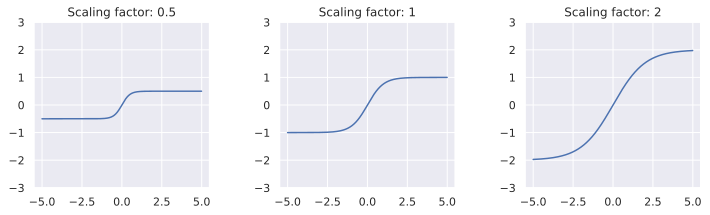

In [12]:
with torch.no_grad():
    x = torch.arange(-5,5,0.01)
    scaling_factors = [0.5, 1, 2]
    sns.set()
    fig, ax = plt.subplots(1, 3, figsize=(12,3))
    for i, scale in enumerate(scaling_factors):
        y = torch.tanh(x / scale) * scale
        ax[i].plot(x.numpy(), y.numpy())
        ax[i].set_title("Scaling factor: " + str(scale))
        ax[i].set_ylim(-3, 3)
    plt.subplots_adjust(wspace=0.4)
    sns.reset_orig()
    plt.show()

Coupling layers generalize to any masking technique we could think of. However, the most common approach for images is to split the input $z$ in half, using a checkerboard mask or channel mask. A checkerboard mask splits the variables across the height and width dimensions and assigns each other pixel to $z_{j+1:d}$. Thereby, the mask is shared across channels. In contrast, the channel mask assigns half of the channels to $z_{j+1:d}$, and the other half to $z_{1:j+1}$. Note that when we apply multiple coupling layers, we invert the masking for each other layer so that each variable is transformed a similar amount of times. 

Let's implement a function that creates a checkerboard mask and a channel mask for us:

In [13]:
def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask

def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in//2, dtype=torch.float32), 
                      torch.zeros(c_in-c_in//2, dtype=torch.float32)])
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask

We can also visualize the corresponding masks for an image of size $8\times 8\times 2$ (2 channels):

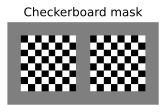

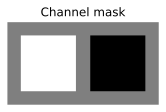

In [14]:
checkerboard_mask = create_checkerboard_mask(h=8, w=8).expand(-1,2,-1,-1)
channel_mask = create_channel_mask(c_in=2).expand(-1,-1,8,8)

show_imgs(checkerboard_mask.transpose(0,1), "Checkerboard mask")
show_imgs(channel_mask.transpose(0,1), "Channel mask")

As a last aspect of coupling layers, we need to decide for the deep neural network we want to apply in the coupling layers. The input to the layers is an image, and hence we stick with a CNN. Because the input to a transformation depends on all transformations before, it is crucial to ensure a good gradient flow through the CNN back to the input, which can be optimally achieved by a ResNet-like architecture. Specifically, we use a Gated ResNet that adds a $\sigma$-gate to the skip connection, similarly to the input gate in LSTMs. The details are not necessarily important here, and the network is strongly inspired from Flow++ [3] in case you are interested in building even stronger models.

In [15]:
class ConcatELU(nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain). 
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """
    
    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)

    
class LayerNormChannels(nn.Module):
    
    def __init__(self, c_in, eps=1e-5):
        """
        This module applies layer norm across channels in an image.
        Inputs: 
            c_in - Number of channels of the input
            eps - Small constant to stabilize std
        """
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y

    
class GatedConv(nn.Module):
    
    def __init__(self, c_in, c_hidden):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = nn.Sequential(
            ConcatELU(),
            nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )
    
    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)

    
class GatedConvNet(nn.Module):
    
    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden),
                       LayerNormChannels(c_hidden)]
        layers += [ConcatELU(),
                   nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)]
        self.nn = nn.Sequential(*layers)
        
        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()
    
    def forward(self, x):
        return self.nn(x)

### Training loop

Finally, we can add Dequantization, Variational Dequantization and Coupling Layers together to build our full normalizing flow on MNIST images. We apply 8 coupling layers in the main flow, and 4 for variational dequantization if applied. We apply a checkerboard mask throughout the network as with a single channel (black-white images), we cannot apply channel mask. The overall architecture is visualized below.


<center width="100%" style="padding: 20px"><img src="vanilla_flow.svg" width="900px"></center>

In [16]:
def create_simple_flow(use_vardeq=True):
    flow_layers = []
    if use_vardeq:
        vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                                       mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                       c_in=1) for i in range(4)]
        flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
    else:
        flow_layers += [Dequantization()]
    
    for i in range(8):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                      mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                      c_in=1)]
        
    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

For implementing the training loop, we use the framework of PyTorch Lightning and reduce the code overhead. If interested, you can take a look at the generated tensorboard file, in particularly the graph to see an overview of flow transformations that are applied. Note that we again provide pre-trained models (see later on in the notebook) as normalizing flows are particularly expensive to train. We have also run validation and testing as this can take some time as well with the added importance sampling.

In [17]:
def train_flow(flow, model_name="MNISTFlow"):
    wandb_logger = WandbLogger(project=model_name, # group runs in "MNIST" project
                               log_model='all') # log all new checkpoints during training
    # Create a PyTorch Lightning trainer
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_name), 
                         logger=wandb_logger,
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=200, 
                         gradient_clip_val=1.0,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=5)
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    train_data_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
    result = None
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename, map_location=device)
        flow.load_state_dict(ckpt['state_dict'])
        result = ckpt.get("result", None)
    else:
        print("Start training", model_name)
        trainer.fit(flow, train_data_loader, val_loader)
    
    # Test best model on validation and test set if no result has been found
    # Testing can be expensive due to the importance sampling.
    if result is None:
        val_result = trainer.test(flow, val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(flow, test_loader, verbose=False)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow.import_samples}
    
    return flow, result

## Multi-scale architecture

One disadvantage of normalizing flows is that they operate on the exact same dimensions as the input. If the input is high-dimensional, so is the latent space, which requires larger computational cost to learn suitable transformations. However, particularly in the image domain, many pixels contain less information in the sense that we could remove them without loosing the semantical information of the image. 

Based on this intuition, deep normalizing flows on images commonly apply a multi-scale architecture [1]. After the first $N$ flow transformations, we split off half of the latent dimensions and directly evaluate them on the prior. The other half is run through $N$ more flow transformations, and depending on the size of the input, we split it again in half or stop overall at this position. The two operations involved in this setup is `Squeeze` and `Split` which we will review more closely and implement below. 

### Squeeze and Split

When we want to remove half of the pixels in an image, we have the problem of deciding which variables to cut, and how to rearrange the image. Thus, the squeezing operation is commonly used before split, which divides the image into subsquares of shape $2\times 2\times C$, and reshapes them into $1\times 1\times 4C$ blocks. Effectively, we reduce the height and width of the image by a factor of 2 while scaling the number of channels by 4. Afterwards, we can perform the split operation over channels without the need of rearranging the pixels. The smaller scale also makes the overall architecture more efficient. Visually, the squeeze operation should transform the input as follows:

<center><img src="Squeeze_operation.svg" width="40%"/></center>

The input of $4\times 4\times 1$ is scaled to $2\times 2\times 4$ following the idea of grouping the pixels in $2\times 2\times 1$ subsquares. Next, let's try to implement this layer:

In [18]:
class SqueezeFlow(nn.Module):
    
    def forward(self, z, ldj, reverse=False):
        B, C, H, W = z.shape
        if not reverse: 
            # Forward direction: H x W x C => H/2 x W/2 x 4C
            z = z.reshape(B, C, H//2, 2, W//2, 2)
            z = z.permute(0, 1, 3, 5, 2, 4)
            z = z.reshape(B, 4*C, H//2, W//2)
        else: 
            # Reverse direction: H/2 x W/2 x 4C => H x W x C
            z = z.reshape(B, C//4, 2, 2, H, W)
            z = z.permute(0, 1, 4, 2, 5, 3)
            z = z.reshape(B, C//4, H*2, W*2)
        return z, ldj

Before moving on, we can verify our implementation by comparing our output with the example figure above:

In [19]:
sq_flow = SqueezeFlow()
rand_img = torch.arange(1,17).view(1, 1, 4, 4)
print("Image (before)\n", rand_img)
forward_img, _ = sq_flow(rand_img, ldj=None, reverse=False)
print("\nImage (forward)\n", forward_img.permute(0,2,3,1)) # Permute for readability
reconst_img, _ = sq_flow(forward_img, ldj=None, reverse=True)
print("\nImage (reverse)\n", reconst_img)

Image (before)
 tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [13, 14, 15, 16]]]])

Image (forward)
 tensor([[[[ 1,  2,  5,  6],
          [ 3,  4,  7,  8]],

         [[ 9, 10, 13, 14],
          [11, 12, 15, 16]]]])

Image (reverse)
 tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [13, 14, 15, 16]]]])


<span style='color:red'>The split operation divides the input into two parts, and evaluates one part directly on the prior. So that our flow operation fits to the implementation of the previous layers, we will return the prior probability of the first part as the log determinant jacobian of the layer. It has the same effect as if we would combine all variable splits at the end of the flow, and evaluate them together on the prior. 

In [20]:
class SplitFlow(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
    
    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, z_split = z.chunk(2, dim=1)
            ldj += self.prior.log_prob(z_split).sum(dim=[1,2,3])
        else:
            z_split = self.prior.sample(sample_shape=z.shape).to(device)
            z = torch.cat([z, z_split], dim=1)
            ldj -= self.prior.log_prob(z_split).sum(dim=[1,2,3])
        return z, ldj

### Building a multi-scale flow

After defining the squeeze and split operation, we are finally able to build our own multi-scale flow. Deep normalizing flows such as Glow and Flow++ [2,3] often apply a split operation directly after squeezing. However, with shallow flows, we need to be more thoughtful about where to place the split operation as we need at least a minimum amount of transformations on each variable. Our setup is inspired by the original RealNVP architecture [1] which is shallower than other, more recent state-of-the-art architectures. 

Hence, for the MNIST dataset, we will apply the first squeeze operation after two coupling layers, but don't apply a split operation yet. Because we have only used two coupling layers and each the variable has been only transformed once, a split operation would be too early. We apply two more coupling layers before finally applying a split flow and squeeze again. The last four coupling layers operate on a scale of $7\times 7\times 8$. The full flow architecture is shown below.

<center width="100%" style="padding: 20px"><img src="multiscale_flow.svg" width="1100px"></center>

Note that while the feature maps inside the coupling layers reduce with the height and width of the input, the increased number of channels is not directly considered. To counteract this, we increase the hidden dimensions for the coupling layers on the squeezed input. The dimensions are often scaled by 2 as this approximately increases the computation cost by 4 canceling with the squeezing operation. However, we will choose the hidden dimensionalities $32, 48, 64$ for the three scales respectively to keep the number of parameters reasonable and show the efficiency of multi-scale architectures. 

In [21]:
def create_multiscale_flow():
    flow_layers = []
    
    vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                                   mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                   c_in=1) for i in range(4)]
    flow_layers += [VariationalDequantization(vardeq_layers)]
    
    flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                  mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                  c_in=1) for i in range(2)]
    flow_layers += [SqueezeFlow()]
    for i in range(2):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=4, c_hidden=48),
                                      mask=create_channel_mask(c_in=4, invert=(i%2==1)),
                                      c_in=4)]
    flow_layers += [SplitFlow(),
                    SqueezeFlow()]
    for i in range(4):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=8, c_hidden=64),
                                      mask=create_channel_mask(c_in=8, invert=(i%2==1)),
                                      c_in=8)]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

We can show the difference in number of parameters below:

In [22]:
def print_num_params(model):
    num_params = sum([np.prod(p.shape) for p in model.parameters()])
    print("Number of parameters: {:,}".format(num_params))

print_num_params(create_simple_flow(use_vardeq=False))
print_num_params(create_simple_flow(use_vardeq=True))
print_num_params(create_multiscale_flow())

Number of parameters: 556,312
Number of parameters: 628,388
Number of parameters: 1,711,818


Although the multi-scale flow has almost 3 times the parameters of the single scale flow, it is not necessarily more computationally expensive than its counterpart. We will compare the runtime in the following experiments as well. 

## Analysing the flows

In the last part of the notebook, we will train all the models we have implemented above, and try to analyze the effect of the multi-scale architecture and variational dequantization.

### Training flow variants

Before we can analyse the flow models, we need to train them first. We provide pre-trained models that contain the validation and test performance, and run-time information. As flow models are computationally expensive, we advice you to rely on those pretrained models for a first run through the notebook.

In [ ]:
flow_dict = {"simple": {}, "vardeq": {}, "multiscale": {}}
flow_dict["simple"]["model"], flow_dict["simple"]["result"] = train_flow(create_simple_flow(use_vardeq=False), model_name="MNISTFlow_simple")
flow_dict["vardeq"]["model"], flow_dict["vardeq"]["result"] = train_flow(create_simple_flow(use_vardeq=True), model_name="MNISTFlow_vardeq")
flow_dict["multiscale"]["model"], flow_dict["multiscale"]["result"] = train_flow(create_multiscale_flow(), model_name="MNISTFlow_multiscale")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Start training MNISTFlow_simple


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | In sizes | Out sizes
------------------------------------------------------------
0 | flows | ModuleList | 556 K  | ?        | ?        
------------------------------------------------------------
556 K     Trainable params
0         Non-trainable params
556 K     Total params
2.225     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yjin/anaconda3/envs/dl2023/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:390: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | In sizes | Out sizes
------------------------------------------------------------
0 | flows | ModuleList | 628 K  | ?        | ?        
------------------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.514     Total estimated model params size (MB)


Start training MNISTFlow_vardeq


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [ ]:
flow_dict["simple"]["result"]

### Density modeling and sampling

Firstly, we can compare the models on their quantitative results. The following table shows all important statistics. The inference time specifies the time needed to determine the probability for a batch of 64 images for each model, and the sampling time the duration it took to sample a batch of 64 images.

In [ ]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [ ]:
import tabulate
from IPython.display import display, HTML

table = [[key, 
          "%4.3f bpd" % flow_dict[key]["result"]["val"][0]["test_bpd"], 
          "%4.3f bpd" % flow_dict[key]["result"]["test"][0]["test_bpd"], 
          "%2.0f ms" % (1000 * flow_dict[key]["result"]["time"]),
          "%2.0f ms" % (1000 * flow_dict[key]["result"].get("samp_time", 0)),
          "{:,}".format(sum([np.prod(p.shape) for p in flow_dict[key]["model"].parameters()]))] 
         for key in flow_dict]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "Validation Bpd", "Test Bpd", "Inference time", "Sampling time", "Num Parameters"])))

As we have intially expected, using variational dequantization improves upon standard dequantization in terms of bits per dimension. Although the difference with 0.04bpd doesn't seem impressive first, it is a considerably step for generative models (most state-of-the-art models improve upon previous models in a range of 0.02-0.1bpd on CIFAR with three times as high bpd). While it takes longer to evaluate the probability of an image due to the variational dequantization, which also leads to a longer training time, it does not have an effect on the sampling time. This is because inverting variational dequantization is the same as dequantization: finding the next lower integer.

When we compare the two models to multi-scale architecture, we can see that the bits per dimension score again dropped by about 0.02bpd. Additionally, the sampling time improved notably despite having more parameters. Thus, we see that the multi-scale flow is not only stronger for density modeling, but also more efficient. 

Next, we can test the sampling quality of the models. We should note that the samples for variational dequantization and standard dequantization are very similar, and hence we visualize here only the ones for variational dequantization and the multi-scale model. However, feel free to also test out the `"simple"` model. The seeds are set to obtain reproducable generations and are not cherry picked.

In [ ]:
pl.seed_everything(44)
samples = flow_dict["vardeq"]["model"].sample(img_shape=[16,1,28,28])
show_imgs(samples.cpu())
#vars(flow_dict["vardeq"]["model"])

In [ ]:
pl.seed_everything(42)
samples = flow_dict["multiscale"]["model"].sample(img_shape=[16,8,7,7])
show_imgs(samples.cpu())

From the few samples, we can see a clear difference between the simple and the multi-scale model. The single-scale model has only learned local, small correlations while the multi-scale model was able to learn full, global relations that form digits. This show-cases another benefit of the multi-scale model. In contrast to VAEs, the outputs are sharp as normalizing flows can naturally model complex, multi-modal distributions while VAEs have the independent decoder output noise. Nevertheless, the samples from this flow are far from perfect as not all samples show true digits. 

### Interpolation in latent space

Another popular test for the smoothness of the latent space of generative models is to interpolate between two training examples. As normalizing flows are strictly invertible, we can guarantee that any image is represented in the latent space. We again compare the variational dequantization model with the multi-scale model below.

In [ ]:
@torch.no_grad()
def interpolate(model, img1, img2, num_steps=8):
    """
    Inputs:
        model - object of ImageFlow class that represents the (trained) flow model
        img1, img2 - Image tensors of shape [1, 28, 28]. Images between which should be interpolated.
        num_steps - Number of interpolation steps. 8 interpolation steps mean 6 intermediate pictures besides img1 and img2
    """
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    z, _ = model.encode(imgs)
    alpha = torch.linspace(0, 1, steps=num_steps, device=z.device).view(-1, 1, 1, 1)
    interpolations = z[0:1] * alpha + z[1:2] * (1 - alpha)
    interp_imgs = model.sample(interpolations.shape[:1] + imgs.shape[1:], z_init=interpolations)
    show_imgs(interp_imgs, row_size=8)

exmp_imgs, _ = next(iter(train_loader))

In [ ]:
pl.seed_everything(42)
for i in range(6):
    interpolate(flow_dict["vardeq"]["model"], exmp_imgs[2*i], exmp_imgs[2*i+1])

In [ ]:
pl.seed_everything(42)
for i in range(6):
    interpolate(flow_dict["multiscale"]["model"], exmp_imgs[2*i], exmp_imgs[2*i+1])

The interpolations of the multi-scale model result in more realistic digits (first row $7\leftrightarrow 8\leftrightarrow 6$, second row $9\leftrightarrow 6$), while the variational dequantization model focuses on local patterns that globally do not form a digit. For the multi-scale model, we actually did not do the "true" interpolation between the two images as we did not consider the variables that were split along the flow (they have been sampled randomly for all samples). However, as we will see in the next experiment, the early variables do not effect the overall image much.

### Visualization of latents in different levels of multi-scale

In the following we will focus more on the multi-scale flow. We want to analyse what information is being stored in the variables split at early layers, and what information for the final variables. For this, we sample 8 images where each of them share the same final latent variables, but differ in the other part of the latent variables. Below we visualize three examples of this:

In [ ]:
pl.seed_everything(44)
for _ in range(3):
    z_init = flow_dict["multiscale"]["model"].prior.sample(sample_shape=[1,8,7,7])
    print("//////////////z_init: ", z_init.shape)
    z_init = z_init.expand(8, -1, -1, -1)
    print("//////////////z_init: ", z_init.shape)
    samples = flow_dict["multiscale"]["model"].sample(img_shape=z_init.shape, z_init=z_init)
    show_imgs(samples.cpu())

We see that the early split variables indeed have a smaller effect on the image. Still, small differences can be spot when we look carefully at the borders of the digits. For instance, in the middle, the top part of the 3 has different thicknesses for different samples although all of them represent the same coarse structure. This shows that the flow indeed learns to separate the higher-level information in the final variables, while the early split ones contain local noise patterns.

### Visualizing Dequantization

As a final part of this notebook, we will look at the effect of variational dequantization. We have motivated variational dequantization by the issue of sharp edges/boarders being difficult to model, and a flow would rather prefer smooth, prior-like distributions. To check how what noise distribution $q(u|x)$ the flows in the variational dequantization module have learned, we can plot a histogram of output values from the dequantization and variational dequantization module. 

In [ ]:
def visualize_dequant_distribution(model : ImageFlow, imgs : torch.Tensor, title:str=None):
    """
    Inputs:
        model - The flow of which we want to visualize the dequantization distribution
        imgs - Example training images of which we want to visualize the dequantization distribution 
    """
    imgs = imgs.to(device)
    ldj = torch.zeros(imgs.shape[0], dtype=torch.float32).to(device)
    with torch.no_grad():
        dequant_vals = []
        for _ in tqdm(range(8), leave=False):
            d, _ = model.flows[0](imgs, ldj, reverse=False)
            dequant_vals.append(d)
        dequant_vals = torch.cat(dequant_vals, dim=0)
    dequant_vals = dequant_vals.view(-1).cpu().numpy()
    sns.set()
    plt.figure(figsize=(10,3))
    plt.hist(dequant_vals, bins=256, color=to_rgb("C0")+(0.5,), edgecolor="C0", density=True)
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()
    
sample_imgs, _ = next(iter(train_loader))

In [ ]:
visualize_dequant_distribution(flow_dict["simple"]["model"], sample_imgs, title="Dequantization")

In [ ]:
visualize_dequant_distribution(flow_dict["vardeq"]["model"], sample_imgs, title="Variational dequantization")

The dequantization distribution in the first plot shows that the MNIST images have a strong bias towards 0 (black), and the distribution of them have a sharp border as mentioned before. The variational dequantization module has indeed learned a much smoother distribution with a Gaussian-like curve which can be modeled much better. For the other values, we would need to visualize the distribution $q(u|x)$ on a deeper level, depending on $x$. However, as all $u$'s interact and depend on each other, we would need to visualize a distribution in 784 dimensions, which is not that intuitive anymore.

## Conclusion

In conclusion, we have seen how to implement our own normalizing flow, and what difficulties arise if we want to apply them on images. Dequantization is a crucial step in mapping the discrete images into continuous space to prevent underisable delta-peak solutions. While dequantization creates hypercubes with hard border, variational dequantization allows us to fit a flow much better on the data. This allows us to obtain a lower bits per dimension score, while not affecting the sampling speed. The most common flow element, the coupling layer, is simple to implement, and yet effective. Furthermore, multi-scale architectures help to capture the global image context while allowing us to efficiently scale up the flow. Normalizing flows are an interesting alternative to VAEs as they allow an exact likelihood estimate in continuous space, and we have the guarantee that every possible input $x$ has a corresponding latent vector $z$. However, even beyond continuous inputs and images, flows can be applied and allow us to exploit the data structure in latent space, as e.g. on graphs for the task of molecule generation [6]. Recent advances in [Neural ODEs](https://arxiv.org/pdf/1806.07366.pdf) allow a flow with infinite number of layers, called Continuous Normalizing Flows, whose potential is yet to fully explore. Overall, normalizing flows are an exciting research area which will continue over the next couple of years.

## References

[1] Dinh, L., Sohl-Dickstein, J., and Bengio, S. (2017). “Density estimation using Real NVP,” In: 5th International Conference on Learning Representations, ICLR 2017. [Link](https://arxiv.org/abs/1605.08803)

[2] Kingma, D. P., and Dhariwal, P. (2018). “Glow: Generative Flow with Invertible 1x1 Convolutions,” In: Advances in Neural Information Processing Systems, vol. 31, pp. 10215--10224. [Link](http://papers.nips.cc/paper/8224-glow-generative-flow-with-invertible-1x1-convolutions.pdf)

[3] Ho, J., Chen, X., Srinivas, A., Duan, Y., and Abbeel, P. (2019). “Flow++: Improving Flow-Based Generative Models with Variational Dequantization and Architecture Design,” in Proceedings of the 36th International Conference on Machine Learning, vol. 97, pp. 2722–2730. [Link](https://arxiv.org/abs/1902.00275)

[4] Durkan, C., Bekasov, A., Murray, I., and Papamakarios, G. (2019). “Neural Spline Flows,” In: Advances in Neural Information Processing Systems, pp. 7509–7520. [Link](http://papers.neurips.cc/paper/8969-neural-spline-flows.pdf)

[5] Hoogeboom, E., Cohen, T. S., and Tomczak, J. M. (2020). “Learning Discrete Distributions by Dequantization,” arXiv preprint arXiv2001.11235v1. [Link](https://arxiv.org/abs/2001.11235)

[6] Lippe, P., and Gavves, E. (2021). “Categorical Normalizing Flows via Continuous Transformations,” In: International Conference on Learning Representations, ICLR 2021. [Link](https://openreview.net/pdf?id=-GLNZeVDuik)

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---